# **Отчёт о выполнении домашнего задания к лекции «Кейс-стади»**

![](https://drive.google.com/uc?export=view&id=1Z1IBh-PuWtaJW5Ft9MgVj6eOSnTiXiBH)

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

matplotlib.style.use("seaborn-paper")
rcParams["figure.figsize"] = 11, 7
%matplotlib inline
import seaborn as sns
import re
import glob
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

%load_ext lab_black

Не думаю, что тут уместно было применять бутстреп, т.к. данных для проверки и так достаточно (тысячи позиций, этого более чем, чтобы обойтись без псевдовыборок), он может только искажение внести)

Замечательно справились и с моделью :)

Для дальнейшего развития рекомендую вам изучить, как можно настраивать параметры модели , чтобы результаты были лучше. Для начала можно почитать вот эту [статью](https://medium.com/@annabiancajones/sentiment-analysis-on-reviews-feature-extraction-and-logistic-regression-43a29635cc81)

В т.ч. можно оптимизировать модель под другую метрику качества (а не accuracy) при помощи функций GridSearchCV или RandomizedSearchCV, чтобы достигать цели уменьшения именно тех ошибок, которые она совершает больше всего.

# **Задание 1**   

## Вернемся к [набору данных о видеоиграх](https://github.com/obulygin/pyda_homeworks/blob/master/stat_case_study/vgsales.csv).

## Ответьте на следующие вопросы:   
1. Как критики относятся к спортивным играм?
2. Критикам нравятся больше игры на PC или на PS4?
3. Критикам больше нравятся стрелялки или стратегии?

## Для каждого вопроса:   
* сформулируйте нулевую и альтернативную гипотезы;
* выберите пороговый уровень статистической значимости;
* опишите полученные результаты статистического теста.

In [2]:
df = pd.read_csv("/home/sk27/learning/STPY-37/cases/video.csv")
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


***
## **1. Как критики относятся к спортивным играм?**
1. Н0: критики относятся к спортивным играм так же, как к играм в целом;   
2. Н1: критики относятся к спортивным играм иначе, чем ко всем играм и это различие статистически значимо.


![Сомнение](https://vprognoze.ru/uploads/posts/2014-10/1414439488_1.jpg)

In [3]:
# подготовим данные
df_task_1 = df.copy()
df_task_1 = df_task_1[["Name", "Genre", "Critic_Score"]].dropna().reset_index(drop=True)

In [4]:
# оценим объём выборки
val = df_task_1[df_task_1["Genre"] == "Sports"].shape[0]
print(f"Количество спортивных игр: {val}")

Количество спортивных игр: 1194


In [5]:
# проверим данные на нормальность распределения (критерий Шапиро-Уилка) для уровня значимости 0.05


def norm_test(data):
    """функция проверяет набор данных на нормальность распределения
    с использованием критерия Шапиро-Уилка"""
    stat, p = stats.shapiro(data)
    print("Statistics=%.3f, p-value=%.3f" % (stat, p))
    alpha = 0.05
    if p > alpha:
        print("Принять гипотезу о нормальности")
    else:
        print("Отклонить гипотезу о нормальности")

In [9]:
data_sport = pd.DataFrame(
    df_task_1[df_task_1["Genre"] == "Sports"]["Critic_Score"]
).reset_index(drop=True)
data_all = pd.DataFrame(df_task_1["Critic_Score"]).reset_index(drop=True)
data_list = [data_sport, data_all]
for data in data_list:
    name = "спортивных игр" if data is data_sport else "генеральной совокупности"
    print(f"Для {name}:")
    norm_test(data)

Для спортивных игр:
Statistics=0.940, p-value=0.000
Отклонить гипотезу о нормальности
Для генеральной совокупности:
Statistics=0.974, p-value=0.000
Отклонить гипотезу о нормальности


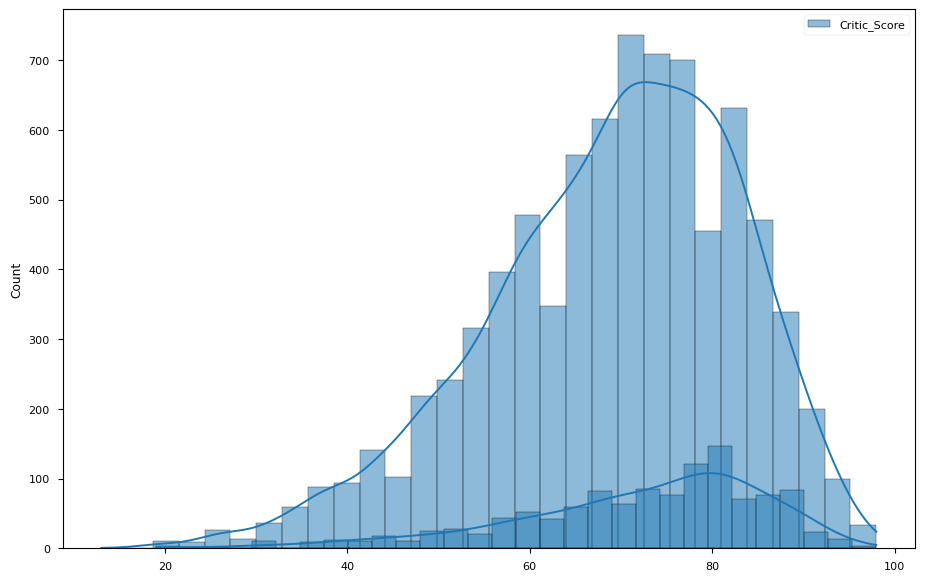

In [28]:
# визуализируем распределение
sns.histplot(data=data_all, kde=True, bins=30)
sns.histplot(data=data_sport, kde=True, bins=30)
plt.show()

1. Распределение данных отличается от нормального.
2. При объёме выборки, превышающем тысячу единиц, следует понизить уровень значимости относительно общепринятого 0.05. Примем **alpha=0.01**

### Для данных, распределение которых отличается от нормального, применим двусторонний (оценка спортивных игр можут быть как выше оценки всех игр, так и ниже её) непараметрический тест Манна-Уитни:

In [11]:
stat, p = stats.mannwhitneyu(data_sport, data_all, alternative="two-sided")
print("statistic=%.3f, p-value=%.3f" % (stat, p))
alpha = 0.01
if p > alpha:
    print("Отличия статистически незначимы")
else:
    print("Отличия статистически значимы")

statistic=5551947.500, p-value=0.000
Отличия статистически значимы


### А какой результат покажет тест Стьюдента? Применим одновыборочный t-тест, позволяющий оценить сходство выборки (спортивные игры) и генеральной совокупности (все игры).

In [12]:
stat, p = stats.ttest_1samp(
    df_task_1[df_task_1["Genre"] == "Sports"]["Critic_Score"],
    df_task_1["Critic_Score"].mean(),
)
print("Статистика=%.3f, p=%.6f" % (stat, p))
alpha = 0.01
if p > alpha:
    print("Отличия статистически незначимы")
else:
    print("Отличия статистически значимы")

Статистика=7.471, p=0.000000
Отличия статистически значимы


### Тест показывает, что вероятность получить такие или ещё более экстремальные отличия между оценкой критиками спортивных игр и оценками критиков игр по генеральной совокупности в целом при условии верности Н0 стремится к 0. Отклоняем Н0 и принимаем Н1 - критики относятся к спортивным ограм как-то иначе. Но как?
### Для ответа на этот вопрос достаточно сопоставить средние значения оценки критиками спортивных игр и игр всех остальных жанров. В отличие от статистического теста среднюю оценку спортивных игр сравним не со средней оценкой по генеральной совокупности, но со средней оценкой игр всех прочих жанров (не спортивных).

In [13]:
spotrs_mean = df_task_1[df_task_1["Genre"] == "Sports"]["Critic_Score"].mean().round(2)
nospotrs_mean = (
    df_task_1[~(df_task_1["Genre"] == "Sports")]["Critic_Score"].mean().round(2)
)
print(
    f"Среднее значение оценки критиками спортивных игр: {spotrs_mean}\nСреднее значение оценки критиками игр иных жанров: {nospotrs_mean}"
)

Среднее значение оценки критиками спортивных игр: 71.97
Среднее значение оценки критиками игр иных жанров: 68.45


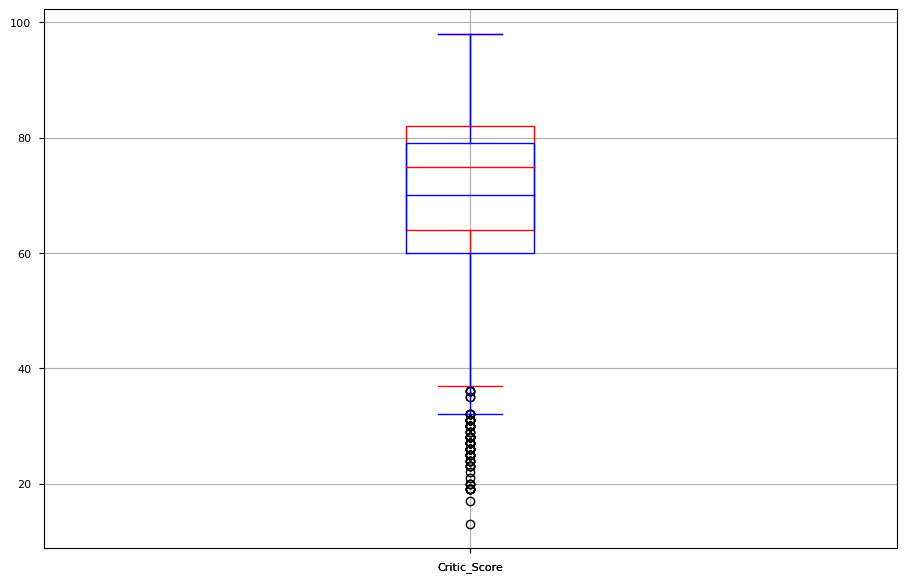

In [27]:
# визуализируем отличия. Они заметны невооружённым глазом

# сравнение оценки спортивных игр и игр всех остальных жанров
pd.DataFrame(df_task_1[df_task_1["Genre"] == "Sports"]["Critic_Score"]).boxplot(
    color="r"
)
pd.DataFrame(df_task_1[~(df_task_1["Genre"] == "Sports")]["Critic_Score"]).boxplot(
    color="b"
)
plt.show()

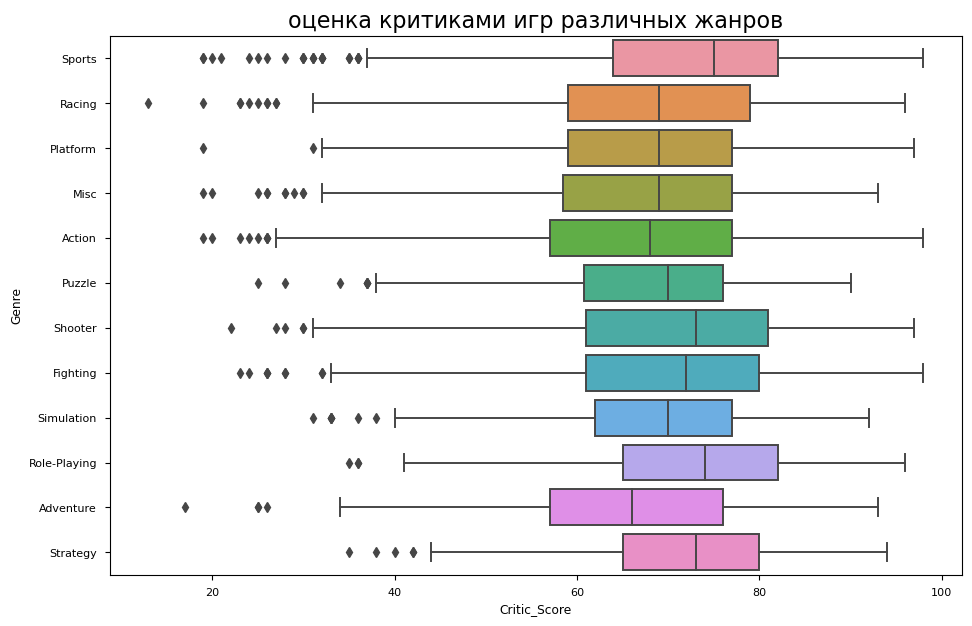

In [26]:
# сравние оценки игр различных жанров
# rcParams["figure.figsize"] = 11, 7
ax = sns.boxplot(x="Critic_Score", y="Genre", data=df_task_1)
ax.set_title(
    "оценка критиками игр различных жанров",
    size=16,
)
plt.show()

## **Вывод**: критики любят спортивные игры.
***

## **2. Критикам нравятся больше игры на PC или на PS4?**
1. H0: критики безразличны к платформе (в частности, PC vs PS4);
2. H1: критики отдают предпочтение играм на одной их этих платформ.

![](https://i.ytimg.com/vi/YyR2LpykQyU/hqdefault.jpg)

In [16]:
# подготовим данные
df_task_2 = df.copy()
df_task_2
df_task_2 = (
    df_task_2[["Name", "Platform", "Critic_Score"]].dropna().reset_index(drop=True)
)
df_task_2

,Name,Platform,Critic_Score
0,Wii Sports,Wii,76.0
1,Mario Kart Wii,Wii,82.0
2,Wii Sports Resort,Wii,80.0
3,New Super Mario Bros.,DS,89.0
4,Wii Play,Wii,58.0
...,...,...,...
8132,Breach,PC,61.0
8133,Bust-A-Move 3000,GC,53.0
8134,Mega Brain Boost,DS,48.0
8135,STORM: Frontline Nation,PC,60.0


### Начнём с того, чем закончили ответ на предудущий вопрос: визуализируем отношение критиков к игровым платформам.

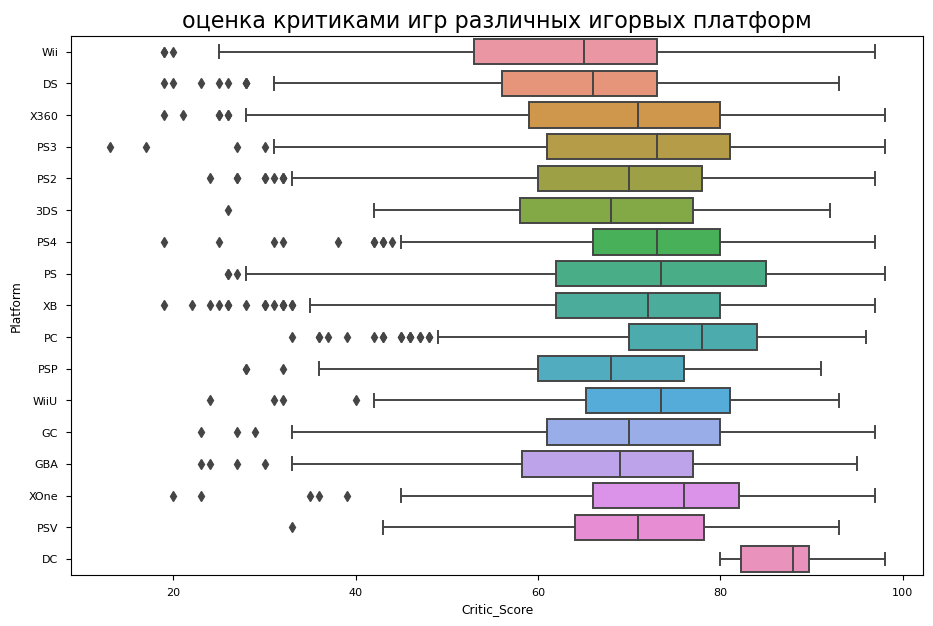

In [25]:
ax = sns.boxplot(x="Critic_Score", y="Platform", data=df_task_2)
ax.set_title(
    "оценка критиками игр различных игорвых платформ",
    size=16,
)
plt.show()

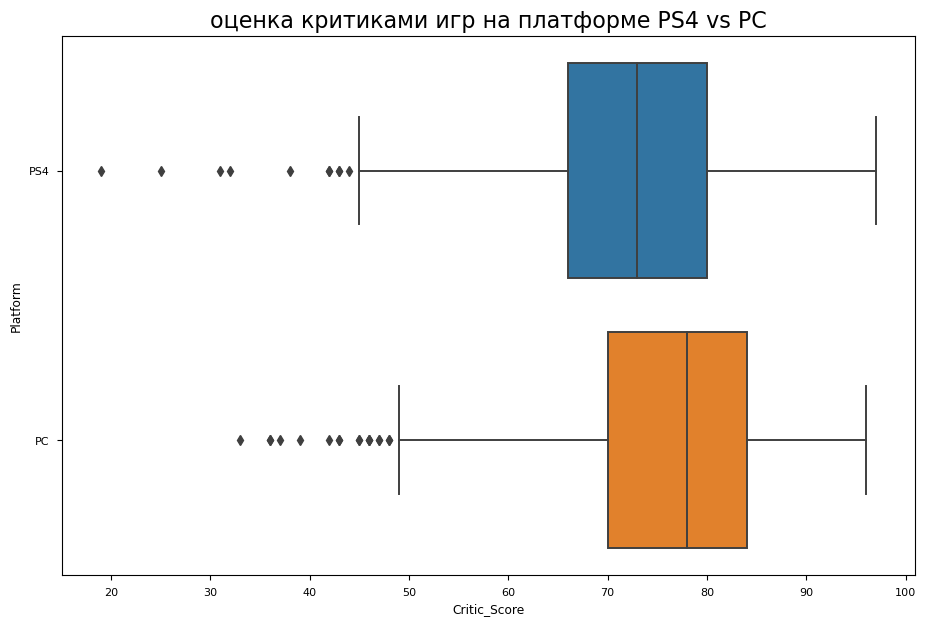

In [24]:
# или более конкретно
ax = sns.boxplot(
    x="Critic_Score",
    y="Platform",
    data=df_task_2[(df_task_2["Platform"] == "PS4") | (df_task_2["Platform"] == "PC")],
)
ax.set_title(
    "оценка критиками игр на платформе PS4 vs PC",
    size=16,
)
plt.show()

In [19]:
# подготовим выборки из генеральной совокупности
df_pc = pd.DataFrame(
    df_task_2[df_task_2["Platform"] == "PC"]["Critic_Score"]
).reset_index(drop=True)
df_ps4 = pd.DataFrame(
    df_task_2[df_task_2["Platform"] == "PS4"]["Critic_Score"]
).reset_index(drop=True)

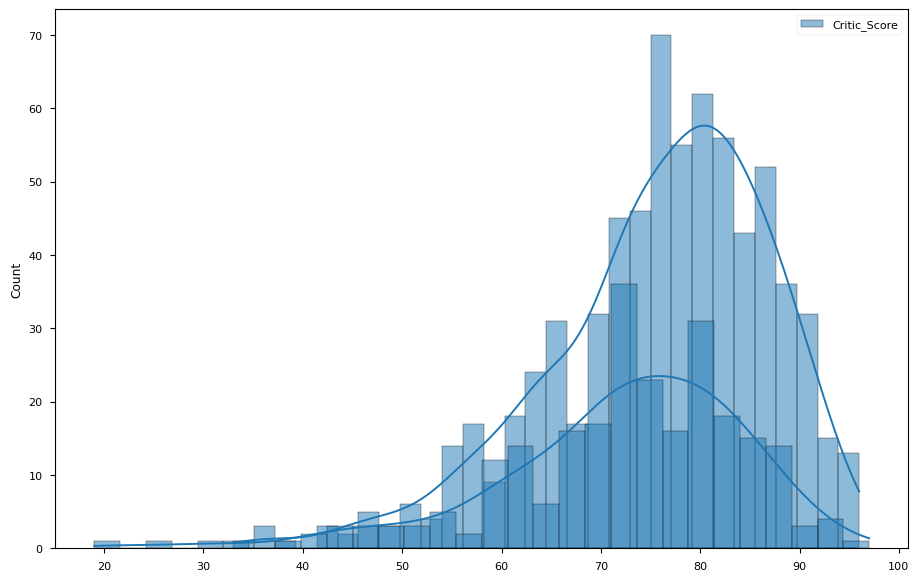

In [23]:
# визуализируем распределение оценок критиков
sns.histplot(data=df_pc, kde=True, bins=30)
sns.histplot(data=df_ps4, kde=True, bins=30)
plt.show()

### Очевидно, что проверка данных на нормальность распределения лишена смысла, распределение близко к распределению Пуассона. Что ж, тогда **ЦПТ** и **бутстрап**.

In [29]:
# напишем необходимую функцию
def bootstrap(data, n, frac):
    """функция возвращает среднее значение n выборок с повторениями
    по <frac> % от исходных данных"""
    df_boot = []
    for i in range(n):
        boot_mean = data.sample(frac=1, replace=True).mean()
        df_boot.append(boot_mean)
    return pd.DataFrame(df_boot)

In [30]:
df_pc_boot = bootstrap(data=df_pc, n=1000, frac=1)
df_ps4_boot = bootstrap(data=df_ps4, n=1000, frac=1)

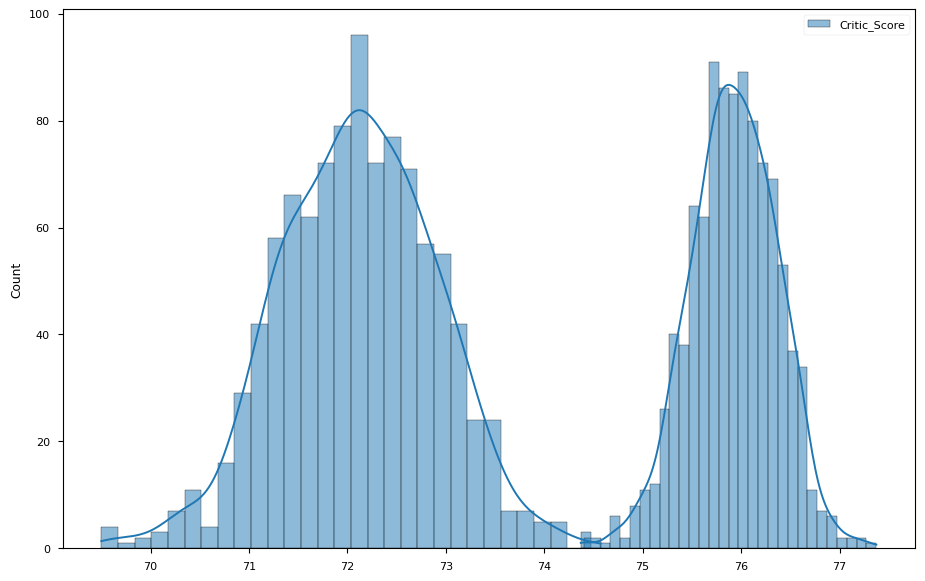

In [31]:
# визуализируем бутстрапированное распределение
sns.histplot(data=df_pc_boot, kde=True, bins=30)
sns.histplot(data=df_ps4_boot, kde=True, bins=30)
plt.show()

### Распределение стало нормальным (ЦПТ же), но результат грядущего применения t-теста, что называется **немного предсказуем**. Размер бутстрапированной выборки 1000 единиц - сохраним значение alpha на прежнем уровне 0.01 и применим t-тест для двух независимых выборок.

### Прежде чем использовать t-тест, необходимо проверить равенство дисперссий. Сделаем это с помощью <a href="https://ru.wikipedia.org/wiki/F-%D1%82%D0%B5%D1%81%D1%82">F-теста</a>. Используем собстенную функцию из материалов занятий.

In [32]:
def f_test(group1, group2):
    f = np.var(group1, ddof=1) / np.var(group2, ddof=1)
    nun = group1.size - 1
    dun = group2.size - 1
    p_value = 1 - stats.f.cdf(f, nun, dun)
    return f, p_value

In [33]:
stat, p = f_test(df_pc_boot, df_ps4_boot)
print("Статистика=%.3f, p=%.5f" % (stat, p))
if p > 0.05:
    print("Не отклоняем нулевую гипотезу, дисперссии, вероятно, одинаковые")
else:
    print("Отклоняем нулевую гипотезу, дисперссии, вероятно, различаются")

Статистика=0.311, p=1.00000
Не отклоняем нулевую гипотезу, дисперссии, вероятно, одинаковые


In [34]:
# дисперсии выборок равны, применяем стандартную проверку
stat, p = stats.ttest_ind(
    df_pc_boot,
    df_ps4_boot,
    equal_var=True,
)
print("Статистика=%.3f, p=%.6f" % (stat, p))
alpha = 0.01
if p > alpha:
    print("Отличия статистически незначимы")
else:
    print("Отличия статистически значимы")

Статистика=132.981, p=0.000000
Отличия статистически значимы


## **Вывод**: критики отдают предпочтение играм на базе PC.
***

## **3. Критикам больше нравятся стрелялки или стратегии?**
1. H0: критикам безразлично, стрелять или стратегически мыслить;
2. H1: критики отдают предпочтение одному из видов игры.

![](https://iphonetech78.files.wordpress.com/2011/06/image43.png)

In [35]:
# подготовим данные
df_task_3 = df_task_1.copy()

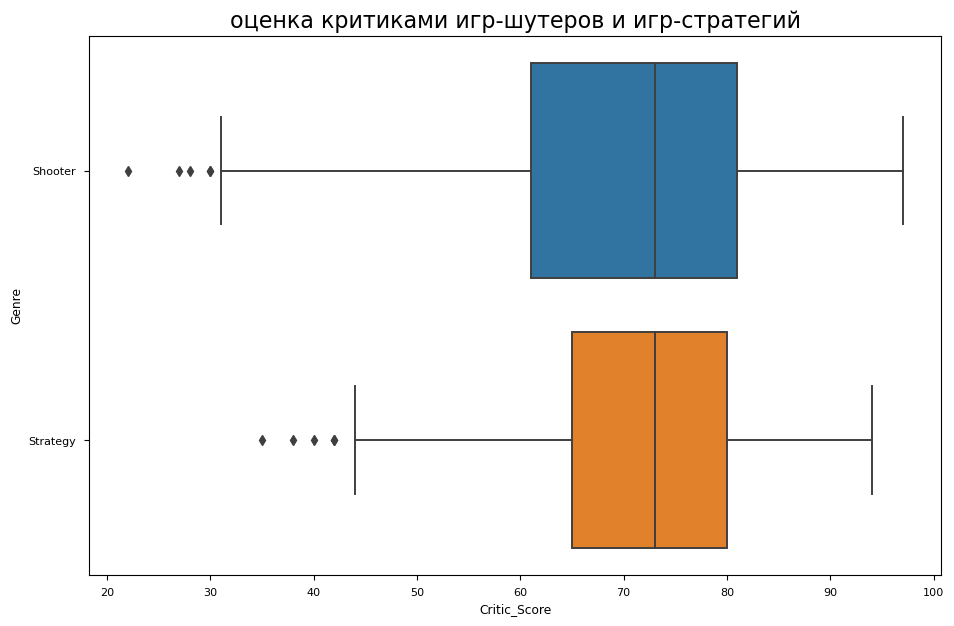

In [36]:
# так что там у них с шутерами и стратегиями?
ax = sns.boxplot(
    x="Critic_Score",
    y="Genre",
    data=df_task_3[
        (df_task_3["Genre"] == "Shooter") | (df_task_3["Genre"] == "Strategy")
    ],
)
ax.set_title(
    "оценка критиками игр-шутеров и игр-стратегий",
    size=16,
)
plt.show()

### Похоже, что среднему критику что стрелять, что мыслить стратегически... причиняет одинаковую радость.

In [37]:
# подготовим выборки из генеральной совокупности
df_shooter = pd.DataFrame(
    df_task_3[df_task_3["Genre"] == "Shooter"]["Critic_Score"]
).reset_index(drop=True)
df_strategy = pd.DataFrame(
    df_task_3[df_task_3["Genre"] == "Strategy"]["Critic_Score"]
).reset_index(drop=True)

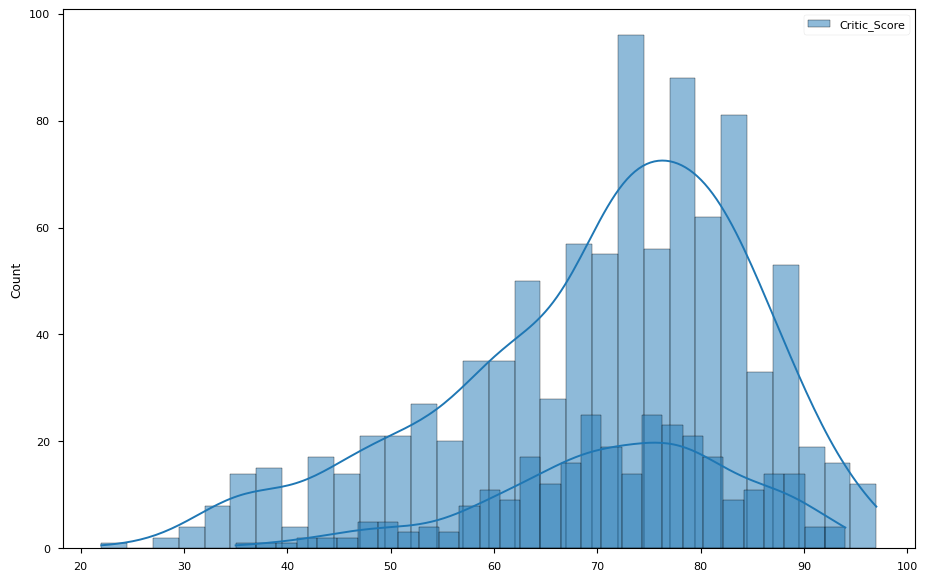

In [38]:
# визуализируем распределение оценок критиков
sns.histplot(data=df_shooter, kde=True, bins=30)
sns.histplot(data=df_strategy, kde=True, bins=30)
plt.show()

In [39]:
# проверим данные на нормальность распределения, просто так...
data_list = [df_shooter, df_strategy]
for data in data_list:
    name = "df_shooter" if data is df_shooter else "df_strategy"
    print(f"Для {name}:")
    norm_test(data)

Для df_shooter:
Statistics=0.957, p-value=0.000
Отклонить гипотезу о нормальности
Для df_strategy:
Statistics=0.974, p-value=0.000
Отклонить гипотезу о нормальности


In [40]:
# оценим приемлемое значение
print(f"Количество данных в выборке df_shooter: {df_shooter.shape[0]}")
print(f"Количество данных в выборке df_strategy: {df_strategy.shape[0]}")

Количество данных в выборке df_shooter: 944
Количество данных в выборке df_strategy: 302


### При таком количестве данных целесообразно принять уровень значимости alpha=0.05

In [41]:
# применим тест Манна-Уитни, раз уж распределение отличается от нормального, а количество значений в выборках не совпадает
print("Тест Манна-Уитни:")
stat, p = stats.mannwhitneyu(df_shooter, df_strategy)
print("Статистика=%.3f, p=%.3f" % (stat, p))
if p > 0.05:
    print("Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые")
else:
    print("Отклоняем нулевую гипотезу, распределения, вероятно, различаются")

Тест Манна-Уитни:
Статистика=136251.500, p=0.248
Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые


### Теперь бутстрапируем выборки и проведём однофакторный дисперсионный анализ с нормально распределёнными данными при alpha=0.01

In [42]:
df_shooter_boot = bootstrap(data=df_shooter, n=5000, frac=1)
df_strategy_boot = bootstrap(data=df_strategy, n=5000, frac=1)

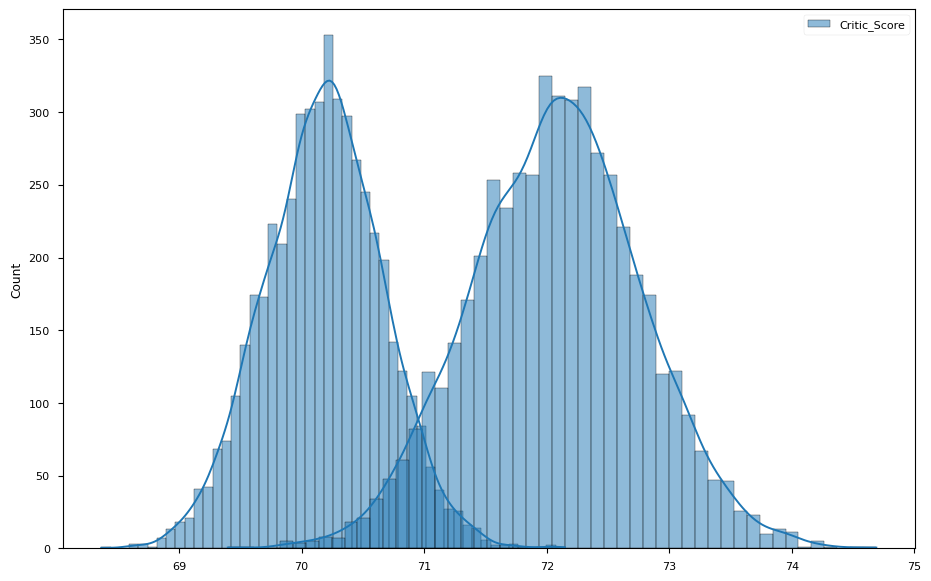

In [43]:
# распределение полученных данных
sns.histplot(data=df_shooter_boot, kde=True, bins=50)
sns.histplot(data=df_strategy_boot, kde=True, bins=50)
plt.show()

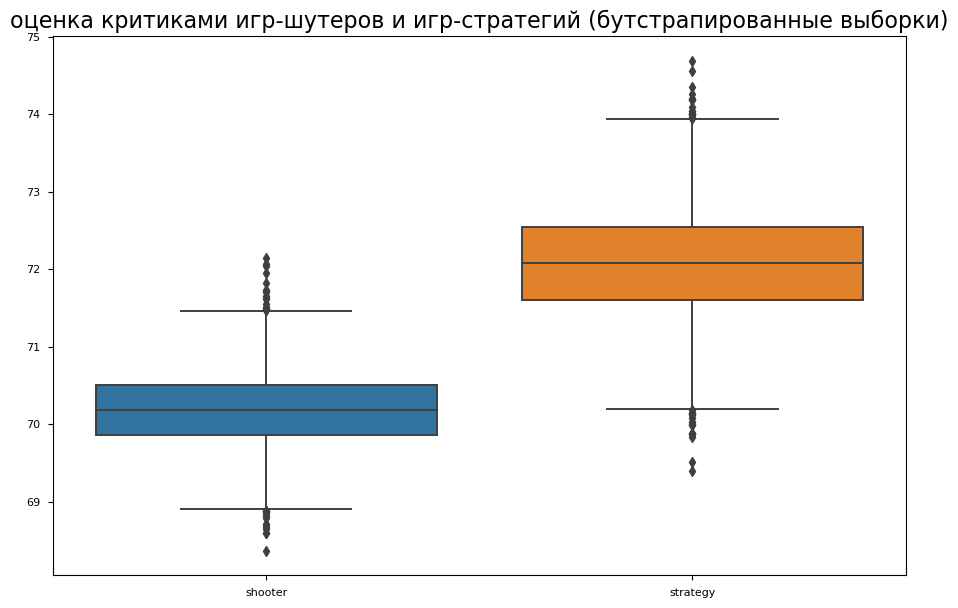

In [44]:
df_boot = pd.concat(
    [
        df_shooter_boot.rename({"Critic_Score": "shooter"}, axis=1),
        df_strategy_boot.rename({"Critic_Score": "strategy"}, axis=1),
    ],
    axis=1,
)
ax = sns.boxplot(
    data=df_boot,
)
ax.set_title(
    "оценка критиками игр-шутеров и игр-стратегий (бутстрапированные выборки)",
    size=16,
)
plt.show()

In [45]:
print("Однофакторый дисперсионный анализ:")
stat, p = stats.f_oneway(df_shooter_boot, df_strategy_boot)
print("Статистика=%.3f, p=%.3f" % (stat, p))
if p > 0.01:
    print("Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые")
else:
    print("Отклоняем нулевую гипотезу, распределения, вероятно, различаются")

Однофакторый дисперсионный анализ:
Статистика=25229.042, p=0.000
Отклоняем нулевую гипотезу, распределения, вероятно, различаются


### Хорошо, а что покажет тест Стьюдента?

In [46]:
# провери равенство дисперсий
stat, p = f_test(df_shooter_boot, df_strategy_boot)
print("Статистика=%.3f, p=%.5f" % (stat, p))
if p > 0.05:
    print("Не отклоняем нулевую гипотезу, дисперссии, вероятно, одинаковые")
else:
    print("Отклоняем нулевую гипотезу, дисперссии, вероятно, различаются")

Статистика=0.481, p=1.00000
Не отклоняем нулевую гипотезу, дисперссии, вероятно, одинаковые


In [47]:
# дисперсии выборок равны, применяем стандартную проверку
stat, p = stats.ttest_ind(
    df_shooter_boot,
    df_strategy_boot,
    equal_var=True,
)
print("Статистика=%.3f, p=%.6f" % (stat, p))
alpha = 0.01
if p > alpha:
    print("Отличия статистически незначимы")
else:
    print("Отличия статистически значимы")

Статистика=-158.837, p=0.000000
Отличия статистически значимы


## **Вывод**: а вывода у меня никакого нет. Точнее, я бы принял результаты теста Манна-Уитни о том, что критики оценивают шуттеры и стратегии прмерно одинаково. Но что делать с результатами бутстрапа?
![Сомнение](https://shoeuntied.files.wordpress.com/2014/07/logo.gif)
***

# Дальше - **дичь**
![](https://massovki.net/thumb/14585796.png)

## Попытаемся использовать при бутстрапировании вместо среднего значения *медианное*:

In [48]:
def bootstrap_median(data, n, frac):
    """функция возвращает среднее значение n выборок с повторениями
    по <frac> % от исходных данных"""
    df_boot = []
    for i in range(n):
        boot_mean = data.sample(frac=1, replace=True).median()
        df_boot.append(boot_mean)
    return pd.DataFrame(df_boot)

In [49]:
df_shooter_boot_median = bootstrap_median(data=df_shooter, n=1000, frac=10)
df_strategy_boot_median = bootstrap_median(data=df_strategy, n=1000, frac=10)

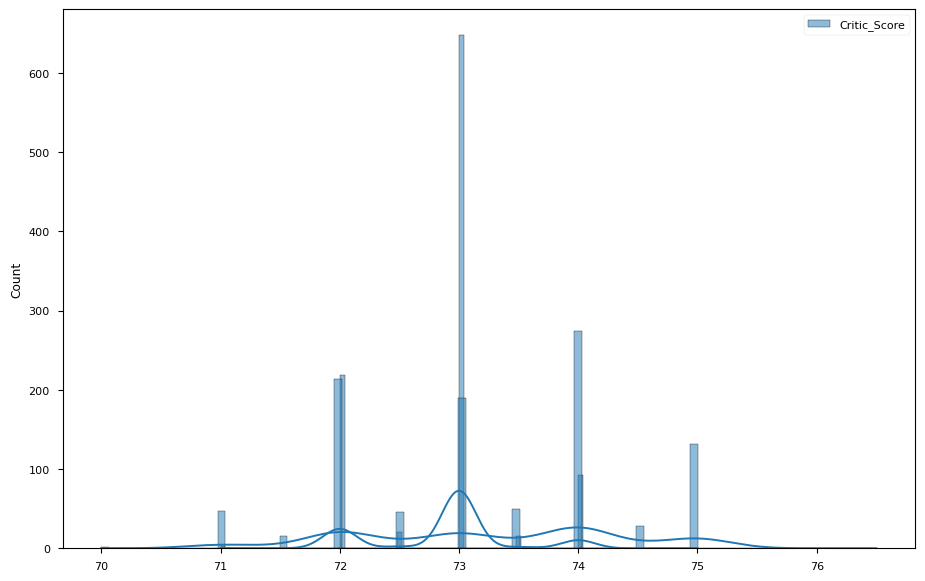

In [50]:
# распределение полученных данных
sns.histplot(data=df_shooter_boot_median, kde=True, bins=100)
sns.histplot(data=df_strategy_boot_median, kde=True, bins=100)
plt.show()

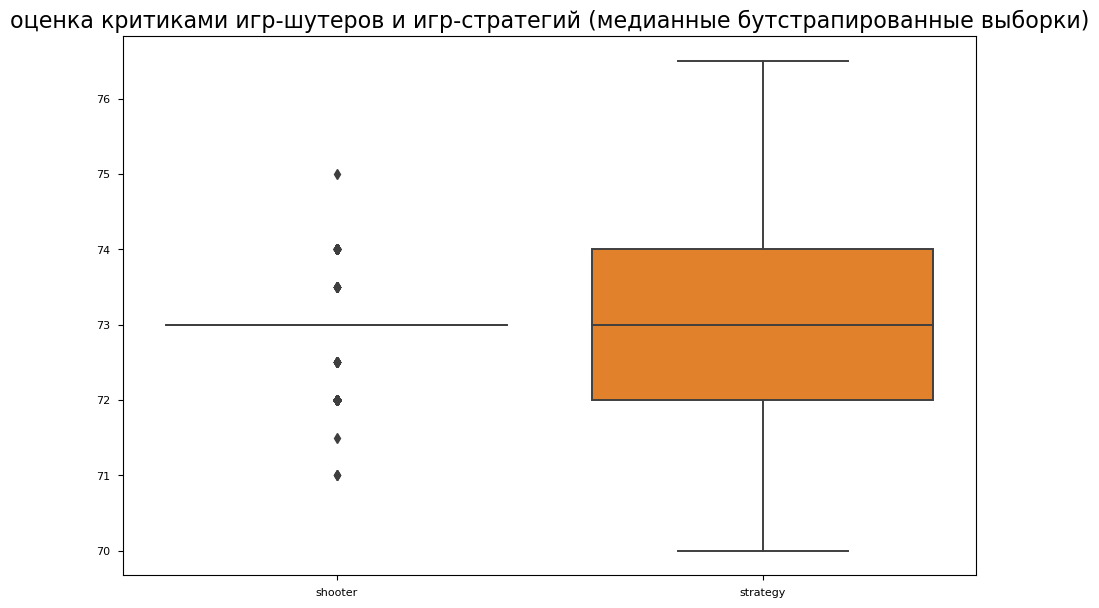

In [51]:
df_boot_median = pd.concat(
    [
        df_shooter_boot_median.rename({"Critic_Score": "shooter"}, axis=1),
        df_strategy_boot_median.rename({"Critic_Score": "strategy"}, axis=1),
    ],
    axis=1,
)
ax = sns.boxplot(
    data=df_boot_median,
)
ax.set_title(
    "оценка критиками игр-шутеров и игр-стратегий (медианные бутстрапированные выборки)",
    size=16,
)
plt.show()

In [52]:
print("Однофакторый дисперсионный анализ:")
stat, p = stats.f_oneway(df_shooter_boot_median, df_strategy_boot_median)
print("Статистика=%.3f, p=%.3f" % (stat, p))
if p > 0.01:
    print("Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые")
else:
    print("Отклоняем нулевую гипотезу, распределения, вероятно, различаются")

Однофакторый дисперсионный анализ:
Статистика=92.574, p=0.000
Отклоняем нулевую гипотезу, распределения, вероятно, различаются


In [53]:
# провери равенство дисперсий
stat, p = f_test(df_shooter_boot_median, df_strategy_boot_median)
print("Статистика=%.3f, p=%.5f" % (stat, p))
if p > 0.05:
    print("Не отклоняем нулевую гипотезу, дисперссии, вероятно, одинаковые")
else:
    print("Отклоняем нулевую гипотезу, дисперссии, вероятно, различаются")

Статистика=0.246, p=1.00000
Не отклоняем нулевую гипотезу, дисперссии, вероятно, одинаковые


In [54]:
# дисперсии выборок равны, применяем стандартную проверку
print("Критерий Стьюдента:")
stat, p = stats.ttest_ind(
    df_shooter_boot_median,
    df_strategy_boot_median,
    equal_var=True,
)
print("Статистика=%.3f, p=%.6f" % (stat, p))
alpha = 0.01
if p > alpha:
    print("Отличия статистически незначимы")
else:
    print("Отличия статистически значимы")

Критерий Стьюдента:
Статистика=-9.622, p=0.000000
Отличия статистически значимы


## А если использовать (да-да!) *усреднённую моду*?

In [55]:
def bootstrap_mode(data, n, frac):
    """функция возвращает среднее значение n выборок с повторениями
    по <frac> % от исходных данных"""
    df_boot = []
    for i in range(n):
        boot_mean = data.sample(frac=1, replace=True).mode().mean()[0]
        df_boot.append(boot_mean)
    return pd.DataFrame(df_boot)

In [56]:
df_shooter_boot_mode = bootstrap_mode(data=df_shooter, n=1000, frac=1)
df_strategy_boot_mode = bootstrap_mode(data=df_strategy, n=1000, frac=1)

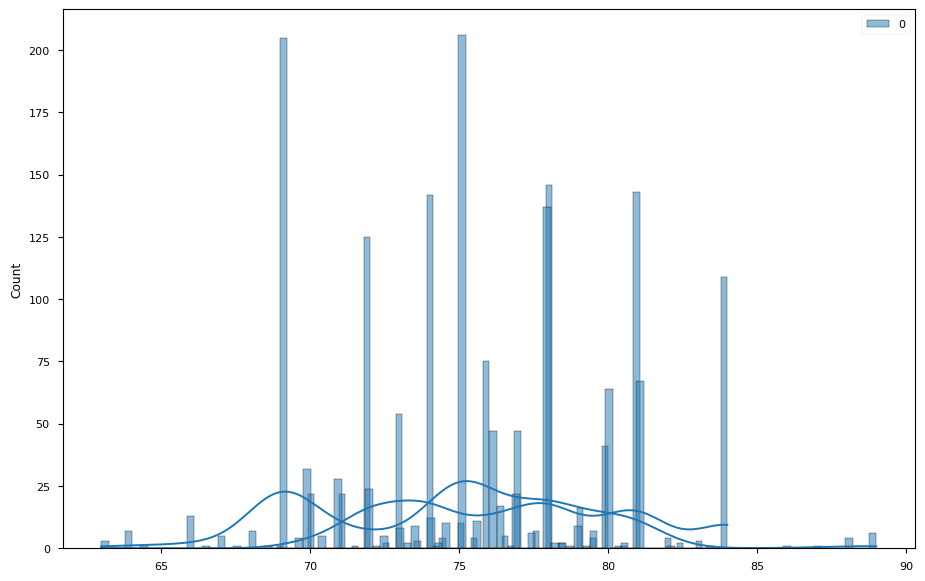

In [57]:
# распределение полученных данных
sns.histplot(data=df_shooter_boot_mode, kde=True, bins=100)
sns.histplot(data=df_strategy_boot_mode, kde=True, bins=100)
plt.show()

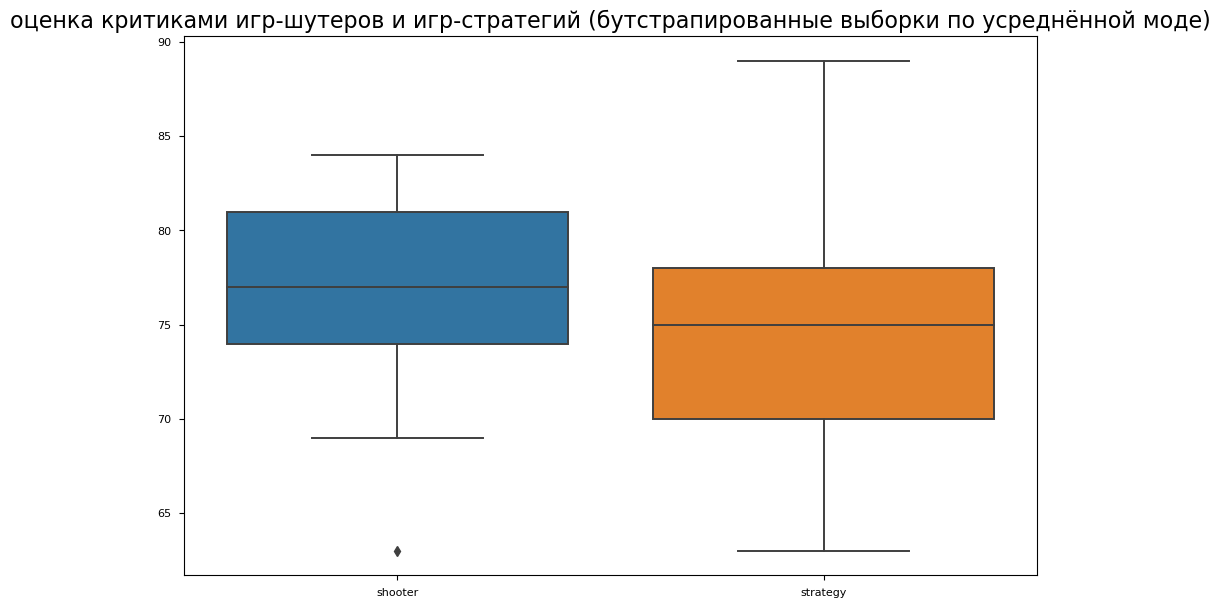

In [58]:
df_boot_mode = pd.concat(
    [
        df_shooter_boot_mode.rename({0: "shooter"}, axis=1),
        df_strategy_boot_mode.rename({0: "strategy"}, axis=1),
    ],
    axis=1,
)
ax = sns.boxplot(
    data=df_boot_mode,
)
ax.set_title(
    "оценка критиками игр-шутеров и игр-стратегий (бутстрапированные выборки по усреднённой моде)",
    size=16,
)
plt.show()

In [59]:
print("Тест Манна-Уитни:")
stat, p = stats.mannwhitneyu(df_shooter_boot_mode, df_strategy_boot_mode)
print("Статистика=%.3f, p=%.3f" % (stat, p))
if p > 0.05:
    print("Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые")
else:
    print("Отклоняем нулевую гипотезу, распределения, вероятно, различаются")

Тест Манна-Уитни:
Статистика=644810.000, p=0.000
Отклоняем нулевую гипотезу, распределения, вероятно, различаются


# Всё говорит о том, что оценки зачимо различаются. Дичь? Или не дичь?

***

# **Задание 2**

## Реализуйте базовую модель логистической регрессии для классификации текстовых сообщений (используемые данные [здесь](https://github.com/obulygin/pyda_homeworks/blob/master/stat_case_study/spam.csv)) по признаку спама. Для этого:

1. Приведите весь текст к нижнему регистру;
2. Удалите мусорные символы;
3. Удалите стоп-слова;
4. Приведите все слова к нормальной форме;
5. Преобразуйте все сообщения в вектора TF-IDF. Вам поможет следующий код:     
`from sklearn.feature_extraction.text import TfidfVectorizer`   
`tfidf = TfidfVectorizer()`   
`tfidf_matrix = tfidf.fit_transform(df.Message)`   
`names = tfidf.get_feature_names()`   
`tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=names)`   
> Можете поэкспериментировать с параметрами TfidfVectorizer      
6. Разделите данные на тестовые и тренировочные в соотношении 30/70, укажите `random_state=42`. Используйте `train_test_split`;     
7. Постройте модель логистической регрессии, укажите `random_state=42`, оцените ее точность на тестовых данных;     
8. Опишите результаты при помощи `confusion_matrix`;    
9. Постройте датафрейм, который будет содержать все исходные тексты сообщений, классифицированные неправильно (с указанием фактического и предсказанного).

In [2]:
# загрузка подготовленных данных
df_message = pd.read_csv(
    "/home/sk27/learning/STPY-37/cases/stat_case_study/spam.csv",
    sep="}",
).reset_index(drop=True)

# сохраним информацию
df_category = df_message.copy()
df_message_0 = df_message.copy()
df_category = pd.DataFrame(df_category["Category"])


df_message.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [3]:
# пропусков нет
df_message.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
# приведение текста к нижнему регистру
df_message["message"] = df_message["Message"].apply(lambda x: x.lower())
df_message.drop("Message", axis=1, inplace=True)

# удаление служебных символов
df_message = pd.DataFrame(
    df_message["message"].apply(lambda x: re.sub("[\W_]+", " ", x))
)
df_message = pd.merge(df_category, df_message, left_index=True, right_index=True)

In [5]:
# удаление стоп-слов

# стоп-слова
nltk.download("stopwords")
stopwords_set = set(stopwords.words("english"))

# функция для удаления стоп-слов
def stpwrd(str_):
    """функция помогает удалить слова из строки"""
    lst = []
    str_list = str_.split()
    for word in stopwords_set:
        lst = [word for word in str_list if word not in stopwords_set]
    return " ".join(lst)


# собственно удаление стоп-слов
df_message = pd.DataFrame(df_message["message"].apply(stpwrd))
df_message = pd.merge(df_category, df_message, left_index=True, right_index=True)

[nltk_data] Downloading package stopwords to /home/sk27/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# приведение слов к нормальной форме (лемматизация)
nltk.download("omw-1.4")
nltk.download("wordnet")
wordnet_lemmatizer = WordNetLemmatizer()

# функция для лемматизации
def lemmatizer(str_):
    """функция помогает привести слова к нормальной форме"""
    lst = []
    str_list = str_.split()
    for word in stopwords_set:
        lst = [wordnet_lemmatizer.lemmatize(word) for word in str_list]
    return " ".join(lst)


# лемматизация
df_message = pd.DataFrame(df_message["message"].apply(lemmatizer))
df_message = pd.merge(df_category, df_message, left_index=True, right_index=True)

[nltk_data] Downloading package omw-1.4 to /home/sk27/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sk27/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# преобразование слов в векторы

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df_message["message"])
names = tfidf.get_feature_names_out()
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=names)

In [8]:
# формирование датасета для обучения модели логистической регрессии

df_message = pd.merge(df_message, tfidf_matrix, left_index=True, right_index=True)
df_message.rename(columns={"message_x": "message"}, inplace=True)
df_message["Category"] = df_message["Category"].map({"ham": 1, "spam": 0})

In [9]:
# логистическая регрессия
X, y = df_message.drop(["Category", "message"], axis=1), df_message["Category"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [10]:
# проверка качества модели сравнением среднеквадратического отклонения в предсказанных данных по обучающей и тестовой выборкам
print(f"MSE обучающей выборки: {mean_squared_error(y_train, model.predict(X_train))}")
print(f"MSE тестовой выборки: {mean_squared_error(y_test, model.predict(X_test))}")
print(
    f"Отношение MSE: {(mean_squared_error(y_train, model.predict(X_train)) / mean_squared_error(y_test, model.predict(X_test))).round(2)}"
)
print(f"Коэффициент детерминации: {model.score(X_test, y_test)}")

MSE обучающей выборки: 0.03487179487179487
MSE тестовой выборки: 0.04126794258373206
Отношение MSE: 0.85
Коэффициент детерминации: 0.958732057416268


In [11]:
# проноз
df_message.insert(1, "Category_predict", model.predict(X).round(0))

In [84]:
# обработка полученных данных
df_message_predict = df_message[["Category", "Category_predict", "message"]]


df_message_predict = df_message_predict.merge(
    df_message_0, left_index=True, right_index=True
)

df_message_predict.insert(
    2,
    "param",
    df_message_predict["Category_x"] - df_message_predict["Category_predict"],
)

df_message_result = df_message_predict.loc[
    abs(df_message_predict["param"]) > 0.0001
].reset_index(drop=True)

df_message_result.insert(
    5, "Cat_predict", df_message_result["Category_predict"].map({1: "ham", 0: "spam"})
)

df_message_result.drop(
    ["Category_x", "Category_predict", "param", "message"], axis=1, inplace=True
)

df_message_result.rename(
    columns={"Category_y": "Category", "Cat_predict": "Category_predict"}, inplace=True
)

In [90]:
# результат
df_message_result

,Category,Category_predict,Message
0,spam,ham,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"
1,spam,ham,"XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL"
2,spam,ham,"England v Macedonia - dont miss the goals/team news. Txt ur national team to 87077 eg ENGLAND to 87077 Try:WALES, SCOTLAND 4txt/ú1.20 POBOXox36504W45WQ 16+"
3,spam,ham,SMS. ac Sptv: The New Jersey Devils and the Detroit Red Wings play Ice Hockey. Correct or Incorrect? End? Reply END SPTV
4,spam,ham,"Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out!"
...,...,...,...
200,spam,ham,"Latest News! Police station toilet stolen, cops have nothing to go on!"
201,spam,ham,For the most sparkling shopping breaks from 45 per person; call 0121 2025050 or visit www.shortbreaks.org.uk
202,spam,ham,http//tms. widelive.com/index. wml?id=820554ad0a1705572711&first=true¡C C Ringtone¡
203,spam,ham,Want explicit SEX in 30 secs? Ring 02073162414 now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX


***

In [12]:
df_message

,Category,Category_predict,message,00,000,000pes,008704050406,0089,0121,01223585236,...,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn,ú1,〨ud
0,1,1,go jurong point crazy available bugis n great world la e buffet cine got amore wat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,ok lar joking wif u oni,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry question std txt rate c apply 08452810075over18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1,u dun say early hor u c already say,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,nah think go usf life around though,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0,0,2nd time tried 2 contact u u 750 pound prize 2 claim easy call 087187272008 now1 10p per minute bt national rate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5568,1,1,ü b going esplanade fr home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5569,1,1,pity mood suggestion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5570,1,1,guy bitching acted like interested buying something else next week gave u free,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
